In [2]:
import scipy
import statsmodels
import sklearn
import theano
import tensorflow
import keras
import glob
import os
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import requests
from datetime import datetime
import time

# Data preparation

In [3]:
#read weather data
weather = pd.read_csv('F:/Research/EnergyEstimation/darksky_chattanooga.csv', index_col=False)
weather['period']=(weather['time']/300).apply(np.floor)
weather1=weather[['humidity','temperature','period']]

In [4]:
#read vehicle data in four seasons
path = r'F:/Research/EnergyEstimation/Data'                    
all_files = glob.glob(os.path.join(path, "Gill147*.csv")) 
df_from_each_file = (pd.read_csv(f) for f in all_files)
allseason = pd.concat(df_from_each_file)
allseason=allseason.sort_values(['Unix Timestamp [ms]'])
allseason['period']=(allseason['Unix Timestamp [ms]']/300000).apply(np.floor)
allseason=allseason.dropna()

In [5]:
#merge data
df = pd.merge(allseason,weather1,on=['period'],how='left')
print(len(df))
df.columns

2344749


Index(['Unix Timestamp [ms]', 'Time ISO', 'Time [US/Eastern]', 'Name',
       'Analysis - fuel - Fuel used [gal]',
       'Analysis - other - Distance driven [mi]',
       'Vehicle - Acceleratorpedal Position [%]',
       'Vehicle - Ambient Air Temperature [°F]',
       'Engine - Engine Fuel Rate [gal/h]', 'Engine - Engine Speed [rpm]',
       'Vehicle - Wheel Based Vehicle Speed [mi/h]', 'GPS - Altitude [m]',
       'GPS - GPS position Latitude', 'GPS - GPS position Longitude',
       'GPS - GPS speed [mi/h]', 'period', 'humidity', 'temperature'],
      dtype='object')

In [6]:
def request_elevation(lat,
                      lon,
                      units='Meters',
                      max_tries=10,
                      sec_btw_tries=1):
    usgs_url = r'https://nationalmap.gov/epqs/pqs.php?'
    usgs_params = {'output': 'json', 'x': lon, 'y': lat, 'units': units}
    for i in range(max_tries):
        try:
            usgs_request = requests.get(url=usgs_url,
                                        params=usgs_params)
            elevation = float(usgs_request.json()['USGS_Elevation_Point_Query_Service']['Elevation_Query']['Elevation'])
            break
        except Exception as e:
            print(e)
            elevation = None
            time.sleep(sec_btw_tries)
    return elevation

In [ ]:
#request elevation
df['elevation']=df.apply(lambda row: request_elevation(row['GPS - GPS position Latitude'], row['GPS - GPS position Longitude']), axis=1)

In [7]:
#process data
df['elevation']=0 
df['elevdiff']=df['elevation'].diff() #ft
df['elevdiff']=df['elevation']*0.000189394 #convert ft to mile
df['distdiff']=df['Analysis - other - Distance driven [mi]'].diff()
df['roadGrade']=df['elevdiff']/df['distdiff']
df['speed'] = df['Vehicle - Wheel Based Vehicle Speed [mi/h]']*1.60934 #convert to km/h
#interpolate if raw data is unfilled
FuelRate = df['Engine - Engine Fuel Rate [gal/h]']
FuelRate = FuelRate.interpolate()
df['FuelRate'] = FuelRate
Speed = df['speed']
Speed = Speed.interpolate()
df['speed'] = Speed
#calculate acceleration
speedms = df['speed']*1000/3600
df['acceleration']=speedms.diff() #unit: m/s^2
# df = df.drop(df[df.FuelRate == 0].index)
df=df[['speed','acceleration','temperature','humidity','roadGrade','FuelRate',]]
df=df.interpolate(method='linear', limit_direction='forward')
df=df.dropna()
print(len(df))

2344746


In [8]:
df.head()

,speed,acceleration,temperature,humidity,roadGrade,FuelRate
3,4.436950,0.195356,41.44,0.63,0.0,1.876
4,5.062984,0.173898,41.44,0.63,0.0,1.757
5,6.155725,0.303539,41.44,0.63,0.0,1.796
6,6.327925,0.047833,41.44,0.63,0.0,1.757
7,6.484031,0.043363,41.44,0.63,0.0,1.717


# Built model

In [18]:
#split train and test datasets
train, test = train_test_split(df,random_state=6,test_size=0.2)

In [21]:
#build ann model
Y_train = train['FuelRate'] #unit: gal/h
X_train = train[['speed','acceleration','temperature','humidity','roadGrade']]
Y_test = test['FuelRate']
X_test = test[['speed','acceleration','temperature','humidity','roadGrade']]
model = Sequential()
model.add(Dense(6,kernel_initializer='normal', input_dim=5, activation ='sigmoid'))
model.add(Dense(6, kernel_initializer='normal', activation ='relu'))
model.add(Dense(1,kernel_initializer='normal', activation ='linear'))
model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mse','mae'])

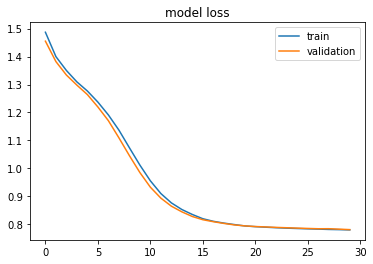

MAE is 0.7787622572674351
MSE is 1.8131272792816162
train final loss is 0.7797070292215175
validation final loss is 0.7807586778950266


In [22]:
#fit model
history = model.fit(X_train, Y_train, validation_split=0.2, epochs=30, 
                    batch_size=16384, verbose = 0)
#performance
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.title('model loss')
plt.legend()
plt.show()

scores = model.evaluate(X_test, Y_test, verbose=0)
print("MAE is",scores[0])
print("MSE is",scores[1])
print("train final loss is",history.history['loss'][-1])
print("validation final loss is",history.history['val_loss'][-1])


# Cross validation

In [23]:
#define the k-fold cross validator
kfold = KFold(n_splits=5, shuffle=True)

In [24]:
# Merge inputs and targets
inputs = np.concatenate((X_train, X_test), axis=0)
targets = np.concatenate((Y_train, Y_test), axis=0)

In [25]:
# K-fold Cross Validation model evaluation
fold_no = 1
acc_per_fold = []
loss_per_fold = []
for train, test in kfold.split(inputs, targets):
  # Define the model architecture
    model = Sequential()
    model.add(Dense(6,kernel_initializer='normal', input_dim=5, activation ='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation ='relu'))
    model.add(Dense(1,kernel_initializer='normal', activation ='linear'))
    model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['mse','mae'])    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],validation_split=0.2,
                        batch_size=256,epochs=30,verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
#     print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
#     acc_per_fold.append(scores[1] * 100)
#     loss_per_fold.append(scores[0])
    print("MAE is",scores[0])
    print("MSE is",scores[1])
    print("train final loss is",history.history['loss'][-1])
    print("validation final loss is",history.history['val_loss'][-1])

    # Increase fold number
    fold_no = fold_no + 1

------------------------------------------------------------------------
Training for fold 1 ...
MAE is 0.7699404374939736
MSE is 1.7521530389785767
train final loss is 0.7688912027037409
validation final loss is 0.7723557454815982
------------------------------------------------------------------------
Training for fold 2 ...
MAE is 0.7565255177521837
MSE is 1.7693028450012207
train final loss is 0.7506238583919344
validation final loss is 0.754273969569889
------------------------------------------------------------------------
Training for fold 3 ...
MAE is 0.7505119916410985
MSE is 1.7625117301940918
train final loss is 0.7510066718249733
validation final loss is 0.7513329623388397
------------------------------------------------------------------------
Training for fold 4 ...
MAE is 0.7773700931630424
MSE is 1.7876652479171753
train final loss is 0.7780846912873706
validation final loss is 0.7774324634878705
------------------------------------------------------------------------


# Prediction

In [26]:
#read a sample trajectory data that needs prediction
trip = pd.read_csv("E:/SUMO/RUIXIAO/newChattanooganet/Data/output/reduced80traj6-7/Route1_trip151687020_065500.csv")
trip['speed']=trip['speed']*(0.01*3.6) 
#km/h
trip['acceleration']=trip['acceleration']*(0.001) 
#m/s2

#simulate datetime
date = '2020-01-05T00:00:00.000Z' #utc format
utc_dt = datetime.strptime(date, '%Y-%m-%dT%H:%M:%S.%fZ')
# Convert UTC datetime to seconds since the Epoch
timestamp0 = (utc_dt - datetime(1970, 1, 1)).total_seconds()
trip['timestamp'] = trip['time_ms']/1000 + timestamp0
trip['period']=(trip['timestamp']/300).apply(np.floor)
trip['roadGrade'] = 0
#merge with weather
trip1 = pd.merge(trip,weather1,on=['period'],how='left')
input2esti=trip1[['speed','acceleration','temperature','humidity','roadGrade']]


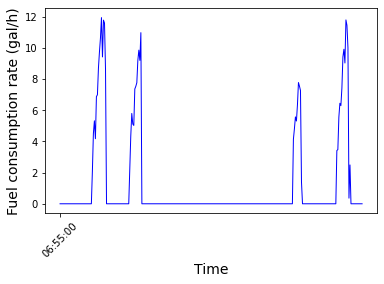

In [27]:
#prdiction and plot results
pre = model.predict(input2esti)

tripf=pd.concat([trip,pd.DataFrame(pre,columns=['FuelRate'])], axis=1) 

fig, ax1 = plt.subplots(figsize=(6, 4))
ax1.plot(tripf.index, tripf.FuelRate, color='blue', linewidth=1)
ax1.set_xticks(tripf.index[::360])
ax1.set_xticklabels(tripf.time[::360], rotation=45)
plt.tight_layout(pad=4)
plt.subplots_adjust(bottom=0.15)
plt.xlabel("Time",fontsize = 14)
plt.ylabel("Fuel consumption rate (gal/h)",fontsize = 14)
plt.show()